In [1]:
import numpy as np
import pandas as pd
from os.path import join

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (14, 6)
plt.style.use('ggplot')
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.disaggregate import fhmm_exact
import time
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# LOADING DATA

data_dir = '/data/REDD/'

train_set = DataSet(join(data_dir, 'redd.h5'))
print('loaded ' + str(len(train_set.buildings)) + ' buildings')

test_set = DataSet(join(data_dir, 'redd.h5'))
print('loaded ' + str(len(test_set.buildings)) + ' buildings')

loaded 6 buildings
loaded 6 buildings


In [3]:
# EXAMINE DATASET METADATA

print_dict(train_set.metadata)
print_dict(test_set.metadata)

In [4]:
# EXAMINE METADATA FOR A SINGLE HOUSE

building_number = 3
print_dict(train_set.buildings[building_number].metadata)
print_dict(test_set.buildings[building_number].metadata)


Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


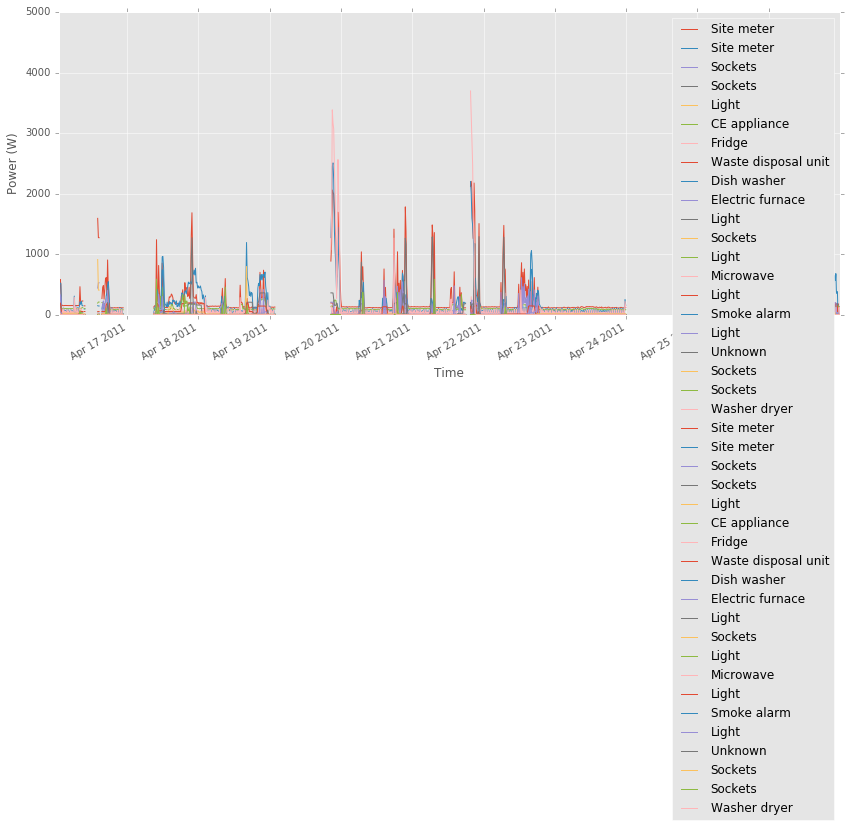

In [5]:
# PLOT SUB-METERED DATA FOR A GIVEN TERM

train_set.set_window(end='2011-04-24 00:00:00')
test_set.set_window(start='2011-04-25 00:00:00', end='2011-04-27 00:00:00')

train_elec = train_set.buildings[building_number].elec
test_elec = test_set.buildings[building_number].elec

train_elec.plot();
plt.xlabel("Time");

test_elec.plot();
plt.xlabel("Time");

In [6]:
# EXAMINE SUB-METERED APPLIANCES

train_elec.appliances
test_elec.appliances


[Appliance(type='fridge', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='light', instance=1),
 Appliance(type='light', instance=2),
 Appliance(type='CE appliance', instance=1),
 Appliance(type='light', instance=5),
 Appliance(type='light', instance=3),
 Appliance(type='electric furnace', instance=1),
 Appliance(type='smoke alarm', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='waste disposal unit', instance=1),
 Appliance(type='light', instance=4),
 Appliance(type='sockets', instance=3),
 Appliance(type='sockets', instance=2),
 Appliance(type='sockets', instance=4),
 Appliance(type='sockets', instance=5),
 Appliance(type='unknown', instance=1)]

In [7]:
# PLOT FRACTION OF ENERGY CONSUMPTION OF EACH APPLIANCE

train_fraction = train_elec.submeters().fraction_per_meter().dropna()
test_fraction = test_elec.submeters().fraction_per_meter().dropna()


19/19 MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
19/19 MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

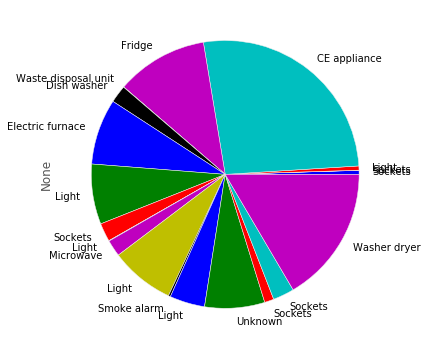

In [8]:
# Create convenient labels train ver.

labels = train_elec.get_labels(train_fraction.index)
plt.figure(figsize=(6,6))
train_fraction.plot(kind='pie', labels=labels);

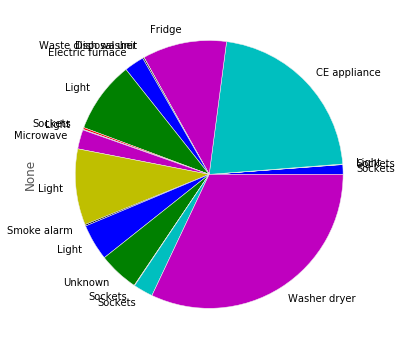

In [9]:
# Create convenient labels test ver.

labels = test_elec.get_labels(test_fraction.index)
plt.figure(figsize=(6,6))
test_fraction.plot(kind='pie', labels=labels);

In [10]:
# TRAINING AND DISAGGREGATION - CO

# Train

start = time.time()

co = CombinatorialOptimisation()
co.train(train_elec)

end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=3, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=3, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=3, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, buildi

In [11]:
# Disaggregate

disag_filename = join(data_dir, 'co_redd-disag.h5')
output = HDFDataStore(disag_filename, 'w')
co.disaggregate(test_elec.mains(), output)
output.close()


Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Including vampire_power = 122.31199646 watts to model...
Estimating power demand for 'ElecMeter(instance=3, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=1)])'
Estimating power demand for 'ElecMeter(instance=4, building=3, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=5, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])'
Estimating power demand for 'ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=3, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])'
Estimating p

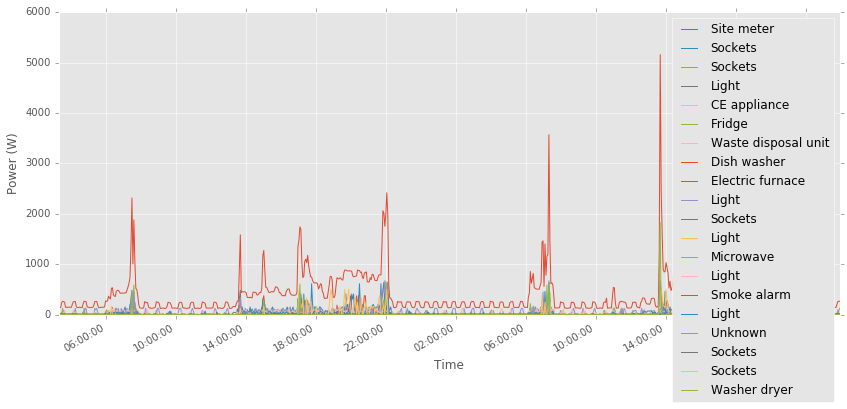

In [12]:
# EXAMINE DISAGGREGATED DATA

disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec
disag_elec.plot()
plt.xlabel("Time")

19/19 ElecMeter(instance=(13, 14), building=3, dataset='CO', appliances=[Appliance(type='washer dryer', instance=1)])

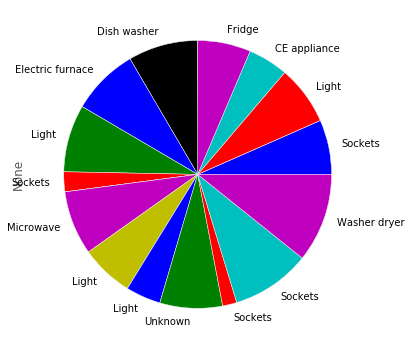

In [13]:
# PLOT FRACTION OF ENERGY CONSUMPTION OF EACH APPLIANCE

disag_fraction = disag_elec.submeters().fraction_per_meter().dropna()

# Create convenient labels

labels = disag_elec.get_labels(disag_fraction.index)
plt.figure(figsize=(6,6))
disag_fraction.plot(kind='pie', labels=labels);

disag.store.close()


Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


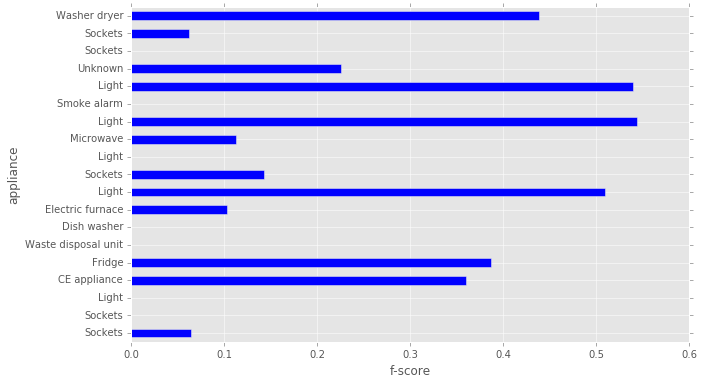

In [14]:
# CALCULATE ACCURACY OF DISAGGREGATION

disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh', figsize=(10,6))
plt.ylabel('appliance');
plt.xlabel('f-score');

disag.store.close()

In [15]:
# Choosing top k appliances

top_k_train_elec = train_elec.submeters().select_top_k(k=7)


19/19 MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


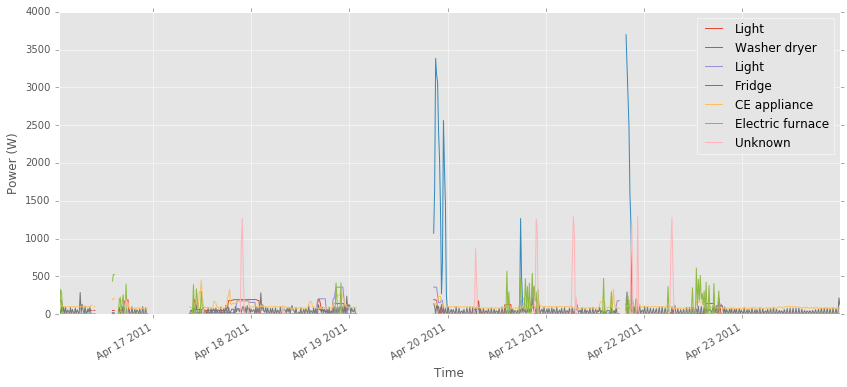

In [17]:
# PLOT SUB-METERED DATA FOR A GIVEN TERM

top_k_train_elec.plot();
plt.xlabel("Time");



Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


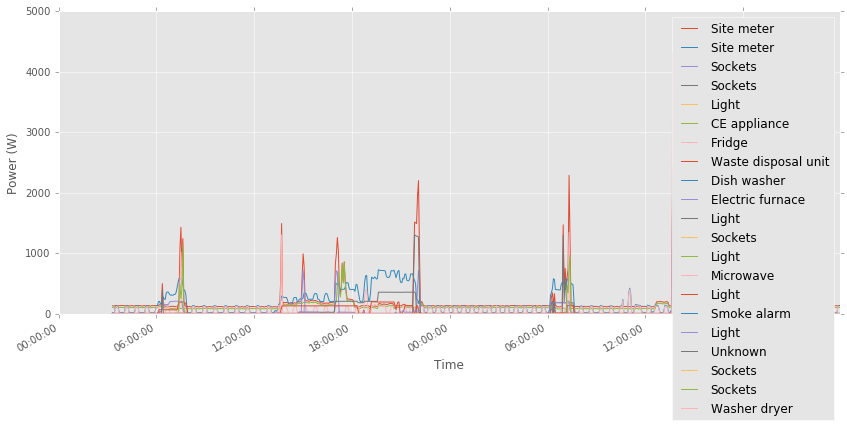

In [18]:
test_elec.plot();
plt.xlabel("Time");

In [19]:
# EXAMINE SUB-METERED APPLIANCES

top_k_train_elec.appliances
test_elec.appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='washer dryer', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='light', instance=1),
 Appliance(type='light', instance=2),
 Appliance(type='CE appliance', instance=1),
 Appliance(type='light', instance=5),
 Appliance(type='light', instance=3),
 Appliance(type='electric furnace', instance=1),
 Appliance(type='smoke alarm', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='waste disposal unit', instance=1),
 Appliance(type='light', instance=4),
 Appliance(type='sockets', instance=3),
 Appliance(type='sockets', instance=2),
 Appliance(type='sockets', instance=4),
 Appliance(type='sockets', instance=5),
 Appliance(type='unknown', instance=1)]

In [20]:
# PLOT FRACTION OF ENERGY CONSUMPTION OF EACH APPLIANCE

train_fraction = top_k_train_elec.submeters().fraction_per_meter().dropna()
test_fraction = test_elec.submeters().fraction_per_meter().dropna()


2/7 MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
19/19 MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=14, building=3, dataset='REDD') ...   

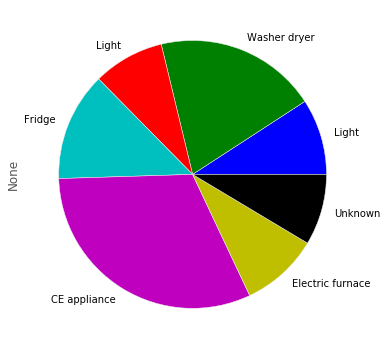

In [21]:
# Create convenient labels train ver.

labels = top_k_train_elec.get_labels(train_fraction.index)
plt.figure(figsize=(6,6))
train_fraction.plot(kind='pie', labels=labels);

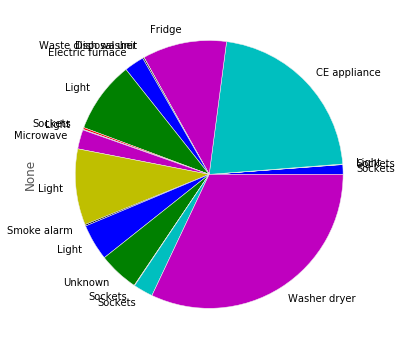

In [22]:
# Create convenient labels test ver.

labels = test_elec.get_labels(test_fraction.index)
plt.figure(figsize=(6,6))
test_fraction.plot(kind='pie', labels=labels);

In [23]:
# TRAINING AND DISAGGREGATION - CO
# selecting top-k appliances

# Train

start = time.time()

co = CombinatorialOptimisation()
co.train(top_k_train_elec, sample_period=60)

end = time.time()
print("Runtime =", end-start, "seconds.")


Training model for submeter 'ElecMeter(instance=17, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=4)])'
Training model for submeter 'MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
)'
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Training model for submeter 'ElecMeter(instance=11, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=2)])'
Training model for submeter 'ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])'
Training model for submeter 'ElecMeter(instance=10, building=3, dataset='

In [24]:
# Disaggregate

disag_filename = join(data_dir, 'top_k_co_redd-disag.h5')
output = HDFDataStore(disag_filename, 'w')
co.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Including vampire_power = 122.31199646 watts to model...
Estimating power demand for 'ElecMeter(instance=17, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=4)])'
Estimating power demand for 'MeterGroup(meters=
  ElecMeter(instance=13, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=14, building=3, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
)'
Estimating power demand for 'ElecMeter(instance=11, building=3, dataset='REDD', appliances=[Appliance(type='light', instance=2)])'
Estimating power demand for 'ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=3, dataset='REDD', appliances=[Appliance(type='CE appliance', instance=1)])'
Estimating power 

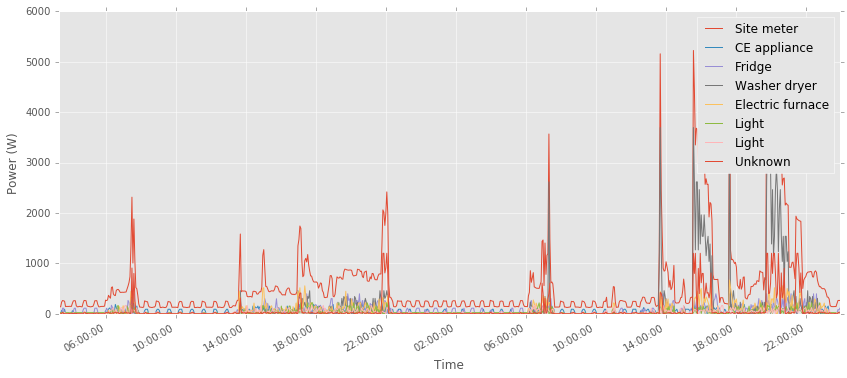

In [25]:
# EXAMINE DISAGGREGATED DATA

disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec
disag_elec.plot()
plt.xlabel("Time")


In [26]:
# PLOT FRACTION OF ENERGY CONSUMPTION OF EACH APPLIANCE

disag_fraction = disag_elec.submeters().fraction_per_meter().dropna()


7/7 ElecMeter(instance=20, building=3, dataset='CO', appliances=[Appliance(type='unknown', instance=1)])

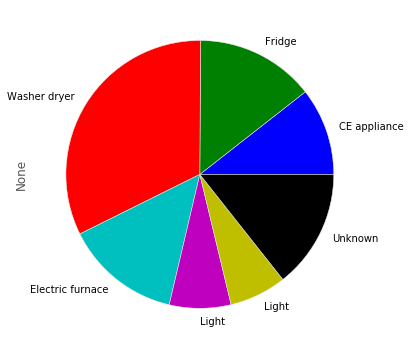

In [27]:
# Create convenient labels

labels = disag_elec.get_labels(disag_fraction.index)
plt.figure(figsize=(6,6))
disag_fraction.plot(kind='pie', labels=labels);

disag.store.close()

Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


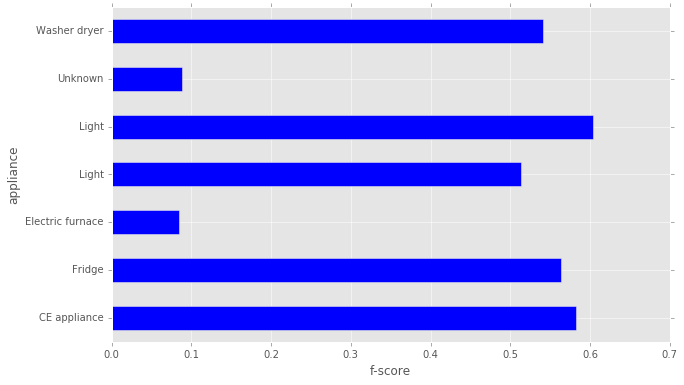

In [28]:
# CALCULATE ACCURACY OF DISAGGREGATION

disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh', figsize=(10,6))
plt.ylabel('appliance');
plt.xlabel('f-score');

disag.store.close()
